# Building Makemore

[Video](https://www.youtube.com/watch?v=PaCmpygFfXo)<br>
[Repository](https://github.com/karpathy/makemore)<br>
[Eureka Labs Discord](https://discord.com/invite/3zy8kqD9Cp)

## Table of Contents

- [Goal](#Goal)
- [The Bigram Language Model](#The-Bigram-Language-Model)
    - [Visualizing the Bigram Model](#Visualizing-the-Bigram-Model)
    - [Addressing Impossibilities](#Addressing-Impossibilities)
    - [Building Probability Distributions](#Building-Probability-Distributions)
    - [Sampling from Probability Distributions](#Sampling-from-Probability-Distributions)
    - [Quality of Generated Names](#Quality-of-Generated-Names)
    - [Model Smoothing](#Model-Smoothing)
- [Neural Network Approach - Same Problem, Different Solution](#Neural-Network-Approach---Same-Problem,-Different-Solution)
    - [Feeding the Network](#Feeding-the-Network)
    - [Regaining Normal Distributions](#Regaining-Normal-Distributions)
    - [Recap](#Recap)
    - [Optimization](#Optimization)
    - [Backward Pass](#Backward-Pass)
- [Summary](#Summary)

## Goal

This lecture will be about [makemore](https://github.com/karpathy/makemore).<br>
Makemore takes a text file as input (like the provided `names.txt`).<br>
Every line in the text file is assumed to be one 'training sample'.<br>
Makemore then learns to generate more samples like those found in the file.

Under the hood, makemore is a **character-level language model**.<br>
Given a partial sequence, makemore tries to learn to predict the respective next character.

> Crucially for us, makemore is a character-level language model that is implemented in a *modern* way.

**Our goal is to understand how makemore works.**<br>
To do so, we will build makemore fully from scratch.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available (way faster calculations with PyTorch)

**We first need to read and prepare the data.**<br>
To do so, we can read the text file and create a list where each element is a line from the file (a name in our case).<br>
In our case, every line is exactly one word (a name), so we call the list `words`.<br>
Given we now have this `words` list, we can do some basic data analysis, like looking at the number of names in the list, or the shortest and longest name in the list, etc.

In [2]:
words = open('../names.txt', 'r').read().splitlines()  # Python list of strings

print("First 10 names:\t", words[:10])  # First ten names, each as separate string
print("Dataset size:\t", len(words))    # Amount of words in dataset
print("Shortest name:\t", min(len(w) for w in words))   # Smallest word in dataset
print("Longest name:\t", max(len(w) for w in words))    # Longest word in dataset

First 10 names:	 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Dataset size:	 32033
Shortest name:	 2
Longest name:	 15


With the **character-level approach**, every name from our `names.txt` can be interpreted as a sequence.<br>
Every sequence is made up of an ordering of a set of characters (letters, numbers, spaces, punctuation, ...) and a sequence length.<br>
In other words, **every name is a character sequence of a certain length, made up of certain characters at certain positions**.

## The Bigram Language Model

The Bigram approach to language modelling processes **exactly two** neighboring characters at a time to predict the next character in the sequence.<br>
This approach only looks at *one* prior character to determine the subsequent *one*, effectively ignoring any possibly surrounding sequence information present in the sample.

**The Bigram approach is a great place to get into language modelling.**

To produce bigrams for a given name, we can slice the name into pairs of neighboring characters.<br>
For example, the name `'emma'` would be sliced into the bigrams `'em'`, `'mm'`, and `'ma'` like so:

In [3]:
for w in words[:1]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]): # Neat two char 'sliding-window' loop
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>


**Note that we added 'special characters' `<S>` and `<E>`** to explicitly denote the beginning and end of a name/sequence.<br>
For the name `emma` our code now produces the bigrams `<S>e, em, mm, ma, a<E>`.

The addition of our 'special characters' produces additional character bigrams for each name.<br>
A model may now interpret that an `m` is likely to follow an `e`, while an `a` is likely to conclude a name, and so on.<br>
But this doesn't help us much yet. We need to quantify the bigrams in some way to be able to make predictions based on them.

The simplest way to derive statistics on which character follows which in our `names.txt` is to count the occurrences of all *possible* bigram combinations.<br>
**We will use a dictionary for that:**

In [4]:
b = {} # Dict for bigram counts

for w in words:
    chs = ['<S>'] + list(w) + ['<E>']    # Extend list of characters of current word by special characters
    for ch1, ch2 in zip(chs, chs[1:]):   # Neat two-char 'sliding-window'
        bigram = (ch1, ch2)              # Bigram is the (ch1, ch2) tuple
        b[bigram] = b.get(bigram, 0) + 1 # If tuple count not exist -> 0 (fallback value if not exist) + 1 (first occurrence count)

Dictionary `b` now holds the occurrence counts for existing character combinations across the entire `names.txt` dataset.<br>
**Let's look into this:**

In [5]:
# b.items() returns tuples like (('<S>', a), 34)
# sorted() by default would sort items by tuple, not by the amounts inside the tuples
# To sort by amount: lambda function replaces sorting key with negative value (amount), sorting high to low
sorted(b.items(), key = lambda keyvalue: -keyvalue[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

The most frequently encountered combination in our `names.txt` is `(('n', '<E>'), 6763)`.<br>
<br>
Looking at the above, it actually seems more convenient and understandable to keep this information in a 2D array rather than a dictionary.<br>
We could do this since the character set is fixed and relatively small.<br>
With such a 2D array representation, we could then more easily access the amount of occurrences of any bigram while maintaining a uniform structure.<br>
On top of that, our bigram statistics become easier to visualize and computationally more efficient to work with.

We should build our 2D array/matrix in such a way that the **rows represent the first characters** and the **columns represent the second characters**.<br>
Every cell then holds the amount of occurrences for the bigram of those two characters.

We have $26$ letters and $2$ special characters, requiring us to build a $28\times 28$ array:

In [6]:
N = torch.zeros((28,28), dtype=torch.int32)  # dtype set explicitly, would otherwise default to torch.float32

# Problem: 
# We only have characters, but we need to index into N using int coordinates
# -> Need for mapping from char to int
chars = sorted(list(set(''.join(words))))  # set() throws out letter duplicates

# Solution:
# We create a mapping dict from letter s to integer i
stoi = {s:i for i,s in enumerate(chars)}
stoi['<S>'] = 26  # Explicitly append special character mappings
stoi['<E>'] = 27

# Our bigram loop from earlier, modified,
# now writes into int-indexed 2D tensor N instead of dict b
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]   # First char to index mapping
        ix2 = stoi[ch2]   # Second char to index mapping
        N[ix1, ix2] += 1  # Increment cell in 2D by 1 (zero is default, see torch.zeros() above)

### Visualizing the Bigram Model

If we want to visualize our newly created `N` numerically, it would look like a total mess.<br>
Let's use matplotlib instead:

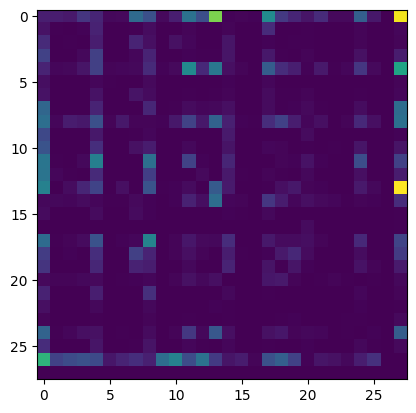

In [7]:
plt.imshow(N);

**Well, this still looks like it doesn't say much.**<br>
We can build something way nicer to more clearly visualize and understand what's going on inside `N`.

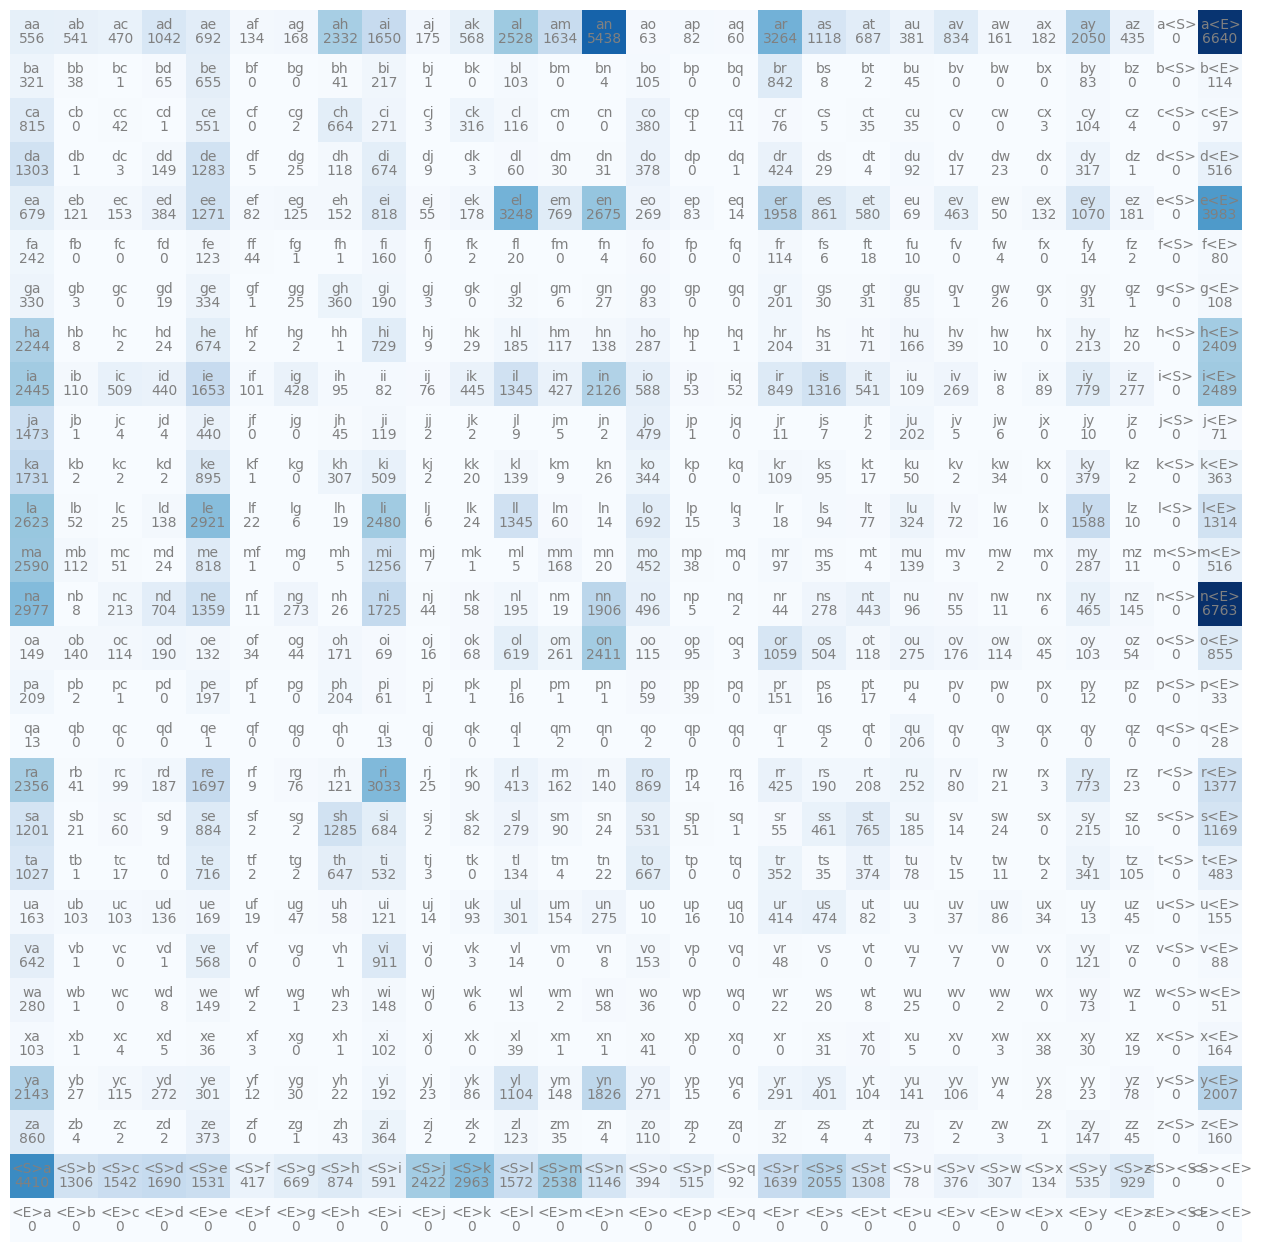

In [8]:
itos = {i:s for s, i in stoi.items()} # Basically reversing stoi element order

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues') # Heatmap basically
for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        chstr = itos[i] + itos[j] # Add text for heat tiles
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
plt.axis('off');

### Addressing Impossibilities

If you render the above, you will see a row and a column that mean trouble for our 'special characters' `<S>` and `<E>`.<br>
There is a column for counting pairs like `(a, <S>)` (second to last) and a row for counting pairs like `(<E>, a)` (last row).<br>
**These are impossible combinations.** A letter never precedes `<S>` and never follows `<E>`.

> This is quite bad. **Considering such impossible combinations skews the statistics.**<br>We should fix the way we create bigrams.<br>This can be achieved by replacing our special `<S>` and `<E>` with just one special character: `.`

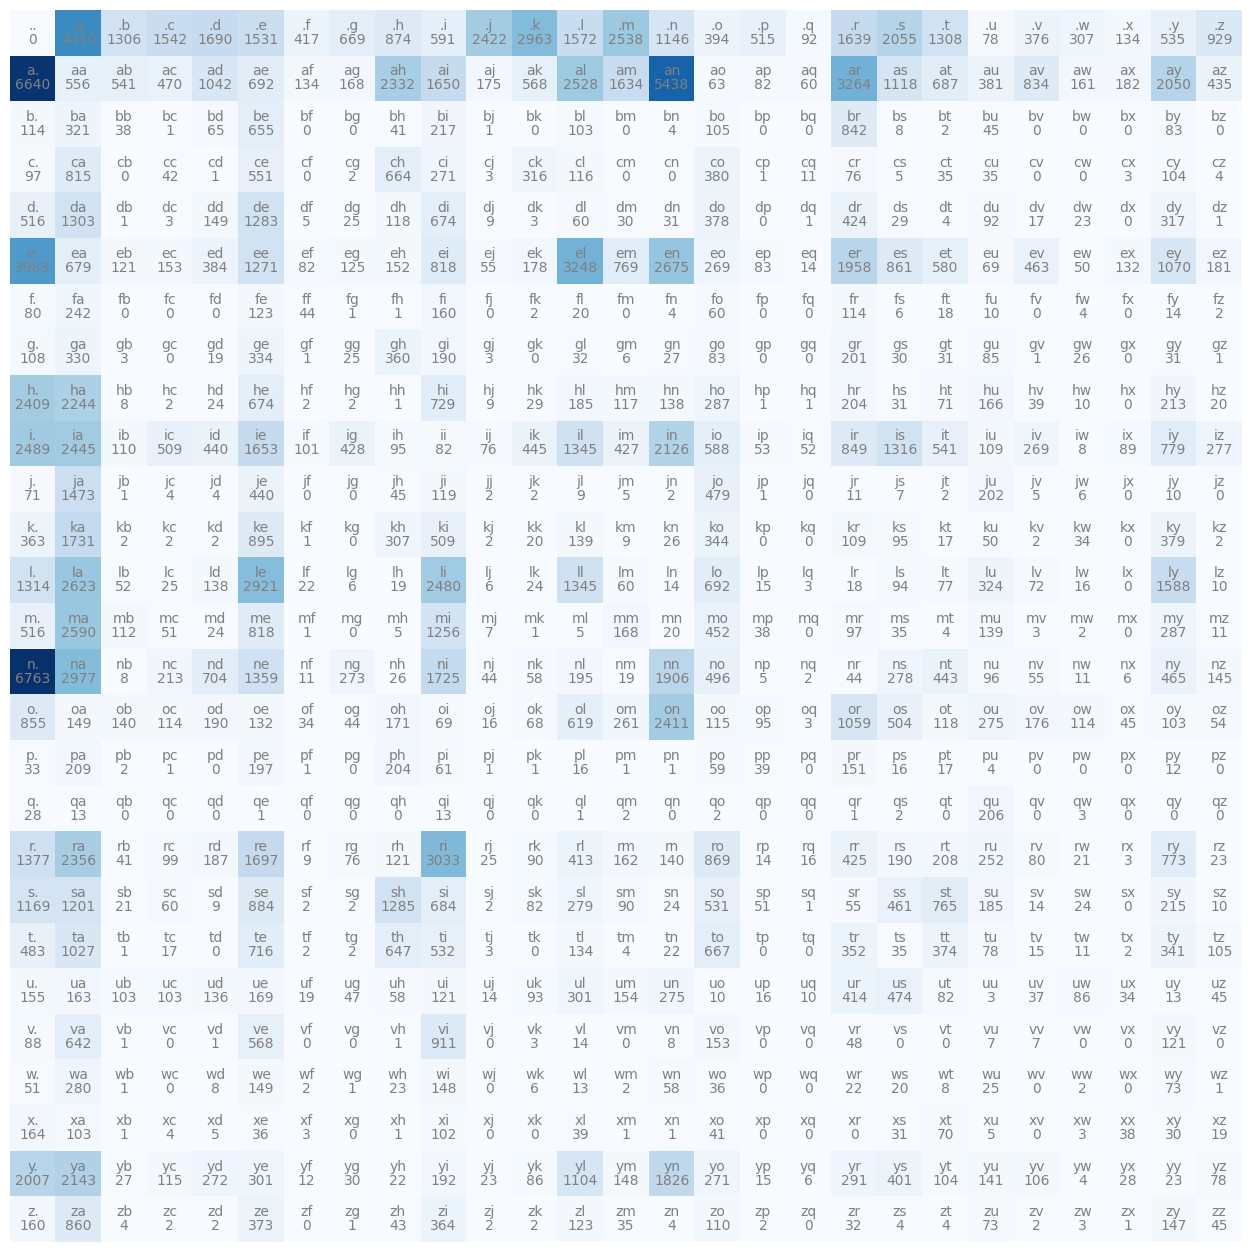

In [9]:
N = torch.zeros((27, 27), dtype=torch.int32) # 28x28 -> 27x27

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # Our single special character now injected at position zero for better looks
itos = {i:s for s,i in stoi.items()}

# Copied from above
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # Neat two-char 'sliding-window'
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1 # Increment cell in 2D by 1

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues') # Heatmap, basically
for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        chstr = itos[i] + itos[j] # Add text for heat tiles
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
plt.axis('off');

Using the single special character `.` removes the redundant column-row problem from before.<br>
`.` in fact correctly occurs before *and* after a name.<br>
Note that even `..` is a legal expression, technically.<br>
*The name is just empty but correctly formed and bounded.*

### Building Probability Distributions

The respective counts for each bigram's occurrences provide us the data to create a probability distribution.<br>
The more frequently a pair occurs, the higher the probability that the subsequent character from that pair will be sampled, given the pair's prior character.

For example, if you have a current letter `b`, the next letter is most likely to be `r` (as `('b','r')` is the most frequent bigram starting with `b`), followed by `i` (as `('r','i')` is the most frequent bigram starting with `r`), and so on. You can see from this approach that we specifically need *row-wise probabilities* (probabilities that sum to 1 across the columns for each row).

We will follow these probabilities and start sampling from the 2D array, row-wise.<br>
We start with tuples beginning with `.`.

In [10]:
# Getting the entire zero-th row 
# (1D array of tuples beginning with '.')
print("Raw first row's combination counts:\n", N[0])
print("Row length:\n", N[0].shape)

Raw first row's combination counts:
 tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)
Row length:
 torch.Size([27])


Suppose our given character is `.`.<br>
The entries of row `N[0]` contain the counts for the bigrams starting with `.`.

To now choose the next character that should follow our `.`, we need to turn these bigram counts into probabilities.<br>
We can do this by dividing each count in the row by the total sum of all the counts in that same row.

Through this step, we obtain a probability distribution over all possible next characters following our `.`.<br>
And this enables us to now sample the next character from that distribution.

In [11]:
p = N[0].float() # Probability vector for the row of bigrams starting with '.' (np.array of floats)
p = p / p.sum()  # Normalize over sum of all the row's counts to obtain distribution

print("First Row's distribution:\n", p)

First Row's distribution:
 tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])


We now stored this new vector of probabilities in `p`.<br>
Let's play with the meaning behind `p` and what we can actually do with it:

In [12]:
# We use a PyTorch Generator to make things random yet repeatable
g = torch.Generator().manual_seed(2147483647) # Create the generate with a fixed seed
p_tmp = torch.rand(3, generator=g) # Generate three random numbers [0;1] with the generator
p_tmp = p_tmp / p_tmp.sum()        # Map the random numbers to a distribution (vectorized, all at once)

print(p_tmp)       # tensor([0.6064, 0.3033, 0.0903])
print(p_tmp.sum()) # tensor(1.), expected for a distribution

tensor([0.6064, 0.3033, 0.0903])
tensor(1.)


### Sampling from Probability Distributions

To now sample from our distribution `p`, we can use `torch.multinomial()`.<br>
It takes a probability distribution and provides a number of integers sampled according to that distribution.

> The larger the `num_samples`, the more precisely we can match the distribution from these samples.

By setting `num_samples` to $1$, conveniently, we can also draw just a single sample from the distribution like so:

In [13]:
g = torch.Generator().manual_seed(2147483647)

# With probability distribution p, create a sample
# [replacement: true] means drawing an element doesn't invalidate drawing this element again
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

# ix is our index, we map it to a letter
print(itos[ix]) # j

j


We just drew a starting character `j` for our first generated name suggestion.<br>
With that, we can move through the array to find the row of tuples starting with `j` and repeat the drawing process for it.

**Generating a name just became a probability-driven loop.**<br>

We can now run this loop for a certain number of iterations to generate a set of name:

In [14]:
g = torch.Generator().manual_seed(2147483647) # Another generator
n = 20 # Let's generate 20 names

for i in range(n):
    ix = 0   # Index of our special '.' character to initialize the name generation
    out = [] # Hold the current name's characters
    while True:
        p = N[ix].float() # Get bigram counts from current row
        p = p / p.sum()   # Normalize respective counts to get probabilities
        # Draw one integer sample from distribution p, that is the character to append and next iteration's row index
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        # If we find we just drew the special '.' character again, we're done generating this name
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


Et voilà, *terrible* name suggestions.

Even though our bigram approach seems to be doing terribly, *it works reasonably*.<br>
It is inefficient, though. **Let's fix that.**

With `p = N[ix].float()` we're always fetching a row and always converting this row's entries from `int` to `float`.<br>
Moreover, for every iteration we also perform `p = p / p.sum()`.<br>
It would be cleaner to prepare a dedicated, pre-processed matrix `P` for these repeated calculations.<br>
It would just be a matrix of pre-calculated probabilities.

Let's implement the performance upgrade with this pre-calculated matrix `P`:

In [15]:
# Setting up probability matrix P, start out by having it hold the float version of the counts
P = N.float()

# One would think the calculation replacing p / p.sum() in the loop would be:
# P /= P.sum() 
# PROBLEM: This would sum over all elements, row- and column-wise -> wrong, we only want row-wise sum

# SOLUTION: This is allowed with PyTorch:
P /= P.sum(1, keepdims=True) 
# P.sum(1, keepdims=True) produces a 27x1 vector (27 values, 1 per row-wise sum)
# The 1 states that the no. of rows is to be kept, but columns are to be summed over per row (exactly what we need)
# keepdims=True produces the result in the shape (27, 1) instead of (27,)
# (27,27) divided by (27,1) is possible in PyTorch through Broadcasting
# For broadcasting to work like here, each dimension must be either equal or 1 (or not existent), which is the case here
# (dimensions will be aligned from right to left!)

g = torch.Generator().manual_seed(2147483647)
n = 20

for i in range(n):
    ix = 0   # Index of our special '.' character to initialize the name generation
    out = [] # Hold the current name's characters
    while True:
        p = P[ix] # Get bigram probabilities from current row (pre-calculated now)
        # Draw one integer sample from distribution p, that is the character to append and next iteration's row index
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        # If we find we just drew the special '.' character again, we're done generating this name
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


In [16]:
# Quick sanity check for broadcasting
# Expected: Every row of P should sum up to 1
print(P.sum(1)) # 1 stands for 'sum across columns'

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


At this point, you're strongly recommended to read through [PyTorch Broadcasting Semantics](https://pytorch.org/docs/stable/notes/broadcasting.html).<br>
**Really understand the broadcasting semantics. Do not skim over this.**

> **Broadcasting** might accept tensor shapes and process them in ways that you didn't intend.<br>You need to understand the use of broadcasting to know whether you made a mistake in the process.<br>Most of the time, it will *not* tell you where you messed up.

### Quality of Generated Names

So far, we have built a bigram language model by counting how often each pair of characters occurs, converting those counts into probabilities, and then sampling from that probability distribution.<br>
We went on to iteratively sample from this model (character-wise) and add matrix `P` as a performance upgrade to avoid redundant calculations.

*But its still bad at coming up with names.*<br>
**But just how bad?** We know that the model's 'knowledge' / bigram-wise probabilities are represented by `P`.<br>
But given that, can we quantify the model's quality with a single value?

Let's look at the bigrams we created from the `names.txt` dataset.<br>
The bigrams to `emma` are `'.e', 'em', 'mm', 'ma', 'a.'`<br>
**But what probability does the model assign to each bigram?**

In [17]:
# Copied from above
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):  # Neat two-char 'sliding-window'
        ix1, ix2 = stoi[ch1], stoi[ch2] # Map bigram chars to indices
        prob = P[ix1, ix2] # Probabilty assigned to bigram (ch1, ch2)
        print(f'{ch1}{ch2}: {prob:.4f}')

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3899
a.: 0.1960


An assigned probability above or below $\frac{1}{27} = 0.0370$ means that we deviate from the mean, *we learned something from the dataset* through the bigram statistics.

**Problem:** Quantify what the bigram probabilities tell us into a single quality-indicating measurement.<br>
**Solution:** *The $\log$-likelihood, i.e. the **sum** of $\ \log(\text{probability})$ over the individual bigram probabilities*<br>
(The logarithm is applied for readability, for convenience basically)

$$\text{log-likelihood} = \sum_{i=1}^{n} \log(P_{b_i})$$
Where $P_{b_i}$ is the probability assigned to bigram $b_i$ by the model.

> **The higher the log-likelihood, the more certain the model is at predicting the next character in a sequence from the dataset.**

In [18]:
log_likelihood = 0.0 # initial log-likelihood
n = 0 # tuple count

# Copied from above, modified to capture the log-likelihood over all names
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        prob = P[ix1, ix2]        # Probabilty assigned to bigram (ch1, ch2)
        logprob = torch.log(prob) # Logarithm of the probability
        log_likelihood += logprob # Add to overall log-likelihood
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}') # Bigram's probability and log-probability

print(f'{log_likelihood=}') # As this is a tensor and we want to see that too
nll = -log_likelihood
print(f'{nll=}')            # Negative log likelihood
print(f'{nll/n}')           # Average negative log likelihood (this is the loss we want to minimize)

log_likelihood=tensor(-559891.7500)
nll=tensor(559891.7500)
2.454094171524048


**Why do we use the negative log-likelihood now?**<br>
Our model assigns probabilities to bigrams as they are observed in the dataset.<br>
A better model will assign higher probabilities to the bigrams that are actually observed in the dataset, leading to a higher log-likelihood.<br>
In optimization, however, we typically want to *minimize* a loss function rather than *maximize* a score.<br>
So, instead of changing the entire optimization process, we can simply take the negative of the log-likelihood and aim to *minimize* that instead.

> The worse/smaller the probability, the more negative the log-likelihood. This way, **the higher the negative log-likelihood `nll`, the worse the model.**<br>
> This `nll` often is normalized as well, resulting in the **average (negative) log-likelihood**.<br>
> This metric is independent of the dataset size and thus more comparable across different datasets.

We calculated an average negative log-likelihood of $2.45$ for our model. *The lower, the better.*<br>
We now to find parameters that reduce this value.

**Goal:**<br>
Maximize the likelihood of the trained data w.r.t. model parameters in `P`<br>
This is equivalent to:
- *Maximizing* the log-likelihood (as log is monotonic)
- *Minimizing* the *negative* log-likelihood
- *Minimizing* the average negative log-likelihood (the size-independent quality-measurement)

From now on, we can evaluate our model by monitoring this loss function (the negative log-likelihood),<br>
as any weakness in the model will be reflected in this value.

**And one such weakness promptly occurs below:**

In [19]:
log_likelihood = 0.0
n = 0

# Copied from above
for w in ['andrejq']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # Neat two-char 'sliding-window'
        ix1, ix2 = stoi[ch1], stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'\n{log_likelihood=}') # As this is a tensor and we want to see that too
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

.a: 0.1377 -1.9829
an: 0.1605 -1.8296
nd: 0.0384 -3.2594
dr: 0.0771 -2.5620
re: 0.1336 -2.0127
ej: 0.0027 -5.9171
jq: 0.0000 -inf
q.: 0.1029 -2.2736

log_likelihood=tensor(-inf)
nll=tensor(inf)
inf


When our model is made to assign probabilities to the bigrams of the name `andrejq`, we get a worst possible average negative log-likelihood of $\infty$.<br>
This is because the bigram `jq` was not present in our `names.txt` dataset, its count is $0$, the likelihood of our model sampling it is therefore $0\%$.<br>
This attributed likelihood then cascades into our final result through $\log(0) = -\infty$, massively distorting the negative log-likelihood.

**It's kinda gross.**

### Model Smoothing

**Model Smoothing** addresses this problem relatively easily.<br>
We basically increment every count we have by $1$ to avoid a count of $0$ from ever occurring.

In [20]:
P = (N+1).float() # Adding more to each count in N means smoothing out distributions more
P /= P.sum(1, keepdims=True) # sum: A 27x1 vector (1 stands for row-wise sum)

We add `+1` to every count in `N`.<br>
Re-running the exact same code as before, smoothing now gives the bigram `jq` a (very small) probability.

> The model is surprised by the `jq` bigram, but not overwhelmed anymore.

In [21]:
log_likelihood = 0.0
n = 0

# Copied from above
for w in ['andrejq']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # Neat two-char 'sliding-window'
        ix1, ix2 = stoi[ch1], stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-27.8672)
nll=tensor(27.8672)
3.4834020137786865


**This is quite a solid bigram character estimation model at this point.**

We've evaluated the performance and removed loopholes through smoothing.<br>
It's still somewhat wobbly, though.

---

## Neural Network Approach - Same Problem, Different Solution

**Now**, we will cast the problem of character estimation into the framework of Neural Networks.<br>
The problem as we tackled it remains the same, the approach changes, the outcome should look similar.

Our neural network **receives a single character** and **outputs the probability distribution over the next possible characters**<br>($27$ in this case).<br><br>
It's going to make guesses on the most likely character to follow.<br>
This will *still* be measurable in performance through the *same* loss function, the negative log-likelihood.

As we have the training data, we know the character that actually comes next per training example.<br>
This can be utilized for tuning the neural network to make better guesses. **Supervised Learning in action.**

In [22]:
#Create training set of all bigrams
xs, ys = [], [] # Input and output character indices

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

# Convert lists to tensors
xs = torch.tensor(xs) # 228146 input character indices (first char of bigram)
ys = torch.tensor(ys) # 228146 output character indices (second char of bigram)

If we were to just produce `xs` and `ys` for the name `.emma.`, they would look like this:

In [23]:
#Create training set of one particular bigram
xs, ys = [], []

itos = {i:s for s, i in stoi.items()}

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        print(f'{ch1}{ch2}: {ix1}\t ->  {ix2}')
        xs.append(ix1)
        ys.append(ix2)

xs, ys = torch.tensor(xs), torch.tensor(ys)
xstr, ystr = [''.join([itos[o[i].item()] for i in range(len(o))]) for o in (xs, ys)]

print()
print(xstr, "->", xs) # 5 input character indices (first char of bigram)
print(ystr, "->", ys) # 5 output character indices (second char of bigram)

.e: 0	 ->  5
em: 5	 ->  13
mm: 13	 ->  13
ma: 13	 ->  1
a.: 1	 ->  0

.emma -> tensor([ 0,  5, 13, 13,  1])
emma. -> tensor([ 5, 13, 13,  1,  0])


> There actually exist `torch.tensor` and also `torch.Tensor`.<br>**Which one should be used?**

(From [here](https://stackoverflow.com/questions/51911749/what-is-the-difference-between-torch-tensor-and-torch-tensor)) 
Every PyTorch Tensor is an instance of `torch.Tensor`, but `torch.tensor` is a function constructing and returning a `torch.Tensor` instance.<br>
Except for when initializing a completely empty tensor, in general, there is no reason to choose `torch.Tensor` over `torch.tensor`.<br>
It should also be noted that `torch.Tensor` is an alias for `torch.FloatTensor`, its `dtype` therefore is `torch.float32` by default.<br>
`torch.tensor` instead infers the correct `dtype` from what you give it unless you specify it yourself.

**It is recommended to use `torch.tensor`.**

### Feeding the Network

It doesn't make sense to use the numeric representations of letters as the input to a single neuron.<br>
The network would refer to the numeric value itself, without any reference to potential context like possible value range, etc.<br>
The letter associated with a number is in its indexed position due to its relation to other letters, and the number itself doesn't represent that.

**One-Hot Encoding** would be a much better representation for that.

> One-hot encoding takes a letter's integer index (e.g., $13$) and creates a vector filled with zeros.<br>It then places a $1$ at index $13$ in this vector, leaving all other positions as $0$.

Let's look at what one-hot encoding would look like for the input `.emma`:

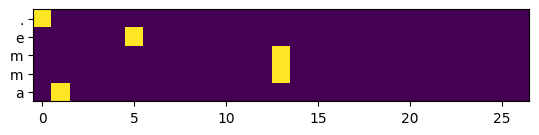

In [24]:
# '. e m m a' is the input
# Output would be 'e m m a .' for it

xenc = F.one_hot(xs, num_classes=27).float() # num_classes provides the vector length
xenc.shape # For '.emma' this will be [5, 27]
plt.yticks(ticks=range(len(xstr)), labels=list(xstr))
plt.imshow(xenc);

The characters from input `.emma` got mapped to `integer` values and then to one-hot vectors of type `float32`.<br>
This in turn means, we finally have an input suitable for NNs.

Let's experiment with neurons.<br>
We'll build a $27$-dimensional neuron and approach it with the letter-wise input of our first name, `.emma` (that's $5$ letters as input).

In [25]:
W = torch.randn((27,1), generator=g) # the neuron: randomly initialized column vector of 27 numbers from normal distribution
a = xenc @ W  # MatMul with one-hot vectors, all at once, batched; '@' is PyTorch's matrix multiplication operator (5x27 @ 27x1 -> 5x1)

print(a) # this is now a 5x1 vector

tensor([[ 0.1066],
        [-1.2464],
        [-0.6378],
        [-0.6378],
        [ 1.8598]])


`W` is a **single** neuron.<br>
Multiplying it by `xenc` makes it 'react' to each of the one-hot encoded character representations *at once*.<br>
The result is a $5\times 1$ sized vector. `.emma` has $5$ characters, we have $1$ neuron.<br>
The vector shows the output, the so-called logit of the neuron per one-hot encoded character.

> As the input was one-hot encoded, the single neuron takes in a "character of the width $27$".<br>
> In this example, it does so for all $5$ letters *at once*. Per $27$-dimensional letter, it outputs exactly one logit.<br>
> It doesn't learn from that output directly, but this is the general idea.<br>
> The key insight is that **as a letter has $27$ dimensions through one-hot encoding, a single neuron has to have $27$ dimensions as well.**<br>
> **Once it has, we can throw multiple one-hot encoded vectors at it at once, like we did above with `xenc`.**

Now, this was only **one** neuron. We want $27$ neurons.<br>
The reason for 'one neuron per possible character in the one-hot vector' will become clear later.

In [26]:
W = torch.randn((27,27), generator=g) # Initialize W randomly again, column matrix of 27x27 numbers (previous was 27x1 for a single neuron, now 27)
a = xenc @ W # @ is PyTorch's matrix multiplication operator, now produces a 5x27 vector

print(a) # 5x27 vector of produced logits

tensor([[ 0.2603,  0.9090, -1.4458,  1.1072, -0.7175, -0.3867, -1.2542,  1.2068,
         -0.7305, -1.0926,  0.3223,  0.0717, -0.2774,  1.1634, -0.6691,  0.6492,
         -0.8157,  0.6404,  1.0442, -1.1571,  0.5107,  0.7593, -1.6086, -0.1607,
         -0.7226,  0.5205,  0.7270],
        [ 0.9641,  0.0471,  0.3096,  1.2087, -0.9954, -0.4485, -1.2345,  1.1220,
         -0.6738,  0.6365, -0.5964,  1.3058,  0.3857, -0.7510,  0.9278, -1.4849,
         -0.2129, -0.9419,  1.5729,  1.0105, -0.1085,  0.6006, -0.7091,  1.9217,
         -0.1818, -0.0954, -0.9253],
        [-0.4645, -0.5206, -0.5579,  1.1087,  0.4149,  0.9557, -0.1471, -1.2532,
         -1.1850,  2.1940,  0.6698,  0.4829,  2.0022, -0.6284, -0.9379,  1.6772,
          0.0039, -0.1460, -1.2915, -0.0748,  1.3272,  1.6676,  1.3931,  0.6540,
         -0.2245, -1.8563,  0.9609],
        [-0.4645, -0.5206, -0.5579,  1.1087,  0.4149,  0.9557, -0.1471, -1.2532,
         -1.1850,  2.1940,  0.6698,  0.4829,  2.0022, -0.6284, -0.9379,  1.6772

For each of the $27$ neurons, we get the neuron's firing rates on each of those $5$ examples, hence the $5\times 27$ vector of logits.

In [27]:
(xenc @ W)[3, 13] # The firing rate of the 14th neuron at the 4th input

tensor(-0.6284)

We now have fed $5$ of the $27$-dimensional inputs into an input layer of $27$ neurons.<br>
**We won't add a Bias or anything.** *This is going to be it on the network structure's side.*

### Regaining Normal Distributions

Intuitively, we'd want the neurons per input (per character) to come together to produce one $27$-dimensional output that could be passed through an activation and transformed into a normal distribution so that, like before, we could use it to decide on what character to choose next.

**Problem:**<br>
Right now we don't do any of that.<br>
Per character, we currently produce $27$ logits. Positive, negative, you name it.<br>
And normal distributions don't just directly come out of any neural network.<br>
**That's just *not* how NNs work.**

**Solution:**<br>
Per character, we don't expect counts for possible combinations like in the matrix visualization<br>
shown above for [Visualizing the Bigram Model](#Visualizing-the-Bigram-Model), but "log-counts".<br>
Based on this interpretation, we exponentiate and normalize by their sum to get them back into the probability space.<br>
Ultimately, this allows us to sample from that distribution just like we did before with the non-NN bigram model.

**...What?**<br>
To turn the arbitrary logits into a valid probability distribution, we first exponentiate them to make them all positive.<br>
Then we normalize the exponentiated logits by dividing by their sum to ensure they sum to $1$ and thus represent a valid probability distribution.<br>
**This process is known as the softmax function:**

$$P_i = \frac{e^{z_i}}{\sum_j e^{z_j}}$$

In [28]:
logits = xenc @ W # logits, different word for log-counts

# These two combined are called Softmax -> Build a probability distribution from logits
counts = logits.exp() # negative numbers are positive below 1, positive numbers are positive above 1
# Let's just say the counts variable holds something like 'fake counts', kinda like in the N matrix of bigram, we process them just the same
probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities

print(probs.shape)    # 5x27, as expected
print(probs[0].sum()) # Will be 1. for any index [0-4]

torch.Size([5, 27])
tensor(1.0000)


It sounds weird, and frankly it looks a bit weird too, but we now have a set of numbers that we can treat just like we treated the actual counts from the bigram approach.<br>
No negatives are present. ("Pretend its a Count-alike").<br>
This way, our task boils down to finding the right weights `W` for the neurons to make the network output the right character probability distributions.

### Recap

Given the example input `.emma.` the NN takes in each character. <br>
We start with the input  `x = .` and the label `y = e` and so on. 

- We get `.`'s index, which is `0`
- We one-hot encode the `.` based on index `0` to form a $27$-dimensional vector
	- This went into the NN as a $27\times 1$ vector
- The input had $27$ different $27$-dimensional neurons produce $27$-dimensional outputs, the logits
- The logits for the `.` therefore form a $1\times 27$ vector (($1,\ 27$) $\times$ ($27,\ 27$) = ($1,\ 27$) logits)
- Softmax gets applied to the logits:
	- The logits are passed through $e^x$ to make sure they are in the positive range $(0;\infty)$ now
	- The $27$ shifted logit values are then normalized by dividing them by their sum to ensure they sum to $1$ as a valid probability distribution should

Think of Softmax as a normalization function, taking weird numbers, returing a positive normal distribution.<br>
This distribution represents the model's prediction of which letter should follow our provided input `.`.

**The question now is:**<br>
How can we find a set of weights `W` that makes the network produce best possible probabilities?

**The operations listed above are differentiable and therefore backpropagatable**.<br><br>
For the sake of completeness, here they are again, written out in code:

In [29]:
# FORWARD-PASS:
# (xs still represents '.emma' as input character indices)

xenc = F.one_hot(xs, num_classes=27).float() # one-hot encode the name's input character indices, now a 5x27 matrix
logits = xenc @ W  # pass the one-hot vectors through the 27 neurons, producing a 5x27 matrix

# Softmax as part of the forward pass
counts = logits.exp() # 'fake counts', kinda like what we accumulated in the N matrix of bigram
probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities

print(probs.shape) # 5x27, one probability distribution per input character

torch.Size([5, 27])


At this point, *this* is what the NN is capable of:

In [30]:
nlls = torch.zeros(len(xs)) # 5

# Five bigrams making up '.emma.'
for i in range(len(xs)):
    #i-th bigram
    x = xs[i].item() # input character-index
    y = ys[i].item() # output character-index
    print("\n-------\n")

    print(f'bigram example tuple {i+1}: ("{itos[x]}", "{itos[y]}") (indexes ({x}, {y}))') # Input is index x, expected output is index y
    print('\t>> input to the neural net:', x, f'({itos[x]})') # Again, x, the index, is the NN's input
    print('\t>> output probabilities from the neural net:\n\t', probs[i]) # We built probs in the above cell
    print('\t>> most likely next character:', itos[probs[i].argmax().item()], f'(index {probs[i].argmax().item()}, likelihood {probs[i].max().item()})') # argmax() returns the index of the highest value in probs[i]
    print('\t>> label (actual next character):', y)

    p = probs[i, y]
    print('\t>> probability assigned by the net to the correct character:', p.item())
    logp = torch.log(p)
    print('\t>> log likelihood:', logp.item())
    nll = -logp
    print('\t>> negative log likelihood:', nll.item())
    nlls[i] = nll

print('\n============\n')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())


-------

bigram example tuple 1: (".", "e") (indexes (0, 5))
	>> input to the neural net: 0 (.)
	>> output probabilities from the neural net:
	 tensor([0.0360, 0.0688, 0.0065, 0.0839, 0.0135, 0.0188, 0.0079, 0.0926, 0.0134,
        0.0093, 0.0383, 0.0298, 0.0210, 0.0887, 0.0142, 0.0530, 0.0123, 0.0526,
        0.0787, 0.0087, 0.0462, 0.0592, 0.0055, 0.0236, 0.0135, 0.0466, 0.0573])
	>> most likely next character: g (index 7, likelihood 0.09264726936817169)
	>> label (actual next character): 5
	>> probability assigned by the net to the correct character: 0.018827952444553375
	>> log likelihood: -3.972412586212158
	>> negative log likelihood: 3.972412586212158

-------

bigram example tuple 2: ("e", "m") (indexes (5, 13))
	>> input to the neural net: 5 (e)
	>> output probabilities from the neural net:
	 tensor([0.0582, 0.0233, 0.0303, 0.0744, 0.0082, 0.0142, 0.0065, 0.0682, 0.0113,
        0.0420, 0.0122, 0.0819, 0.0327, 0.0105, 0.0561, 0.0050, 0.0179, 0.0087,
        0.1070, 0.0610, 0.

**That loss is not good at all**, but we could just re-sample the network weights.<br>
Maybe we get a better outcome? A better option would be to not leave this up to chance. 

**Let's optimize the weights `W` systematically.**

### Optimization

**By chance**, adding $1$ to the generator seed for weight initialization happens to produce a smaller overall loss.<br>
*But waiting for randomness to return optimality is time-consuming amateur-hour.*

> Computing the gradients of the loss with respect to the matrix `W` (per example), we can tune `W` into an optimizing direction.<br>**This is the gradient-based optimization we learnt about in the [last lecture](../N001%20-%20Building%20Micrograd/N001%20-%20Micrograd.ipynb)**.

For the example input `.emma` this means the specific parts of the neuron activations have to be altered respectively:

In [32]:
# Activations of the respective character input
print('input ".", output "e":', probs[0, 5])  # input '.', probability for 'e' to be drawn
print('input "e", output "m":', probs[1, 13]) # input 'e', probability for 'm' to be drawn, etc.
print('input "m", output "m":', probs[2, 13])
print('input "m", output "a":', probs[3, 1])
print('input "a", output ".":', probs[4, 0])

input ".", output "e": tensor(0.0188)
input "e", output "m": tensor(0.0105)
input "m", output "m": tensor(0.0092)
input "m", output "a": tensor(0.0102)
input "a", output ".": tensor(0.0342)


As we want to *change* these particular probabilities, we need to *access* them.<br>
Turns out, we can do this pretty nicely with PyTorch:

In [ ]:
# Over the length of probs (dimension 0, probs is still 5x27), we pluck out per row
# (a row is 27 wide) the corresponding index stated in ys (which is shape 5) at the same index as the row
target_probs = probs[torch.arange(len(probs)), ys] # The probabilities the NN assigns to the correct next character for ., e, m, m, a respectively

# target_probs basically states:
# - probability of 'e' coming after '.' is target_probs[0]
# - probability of 'm' coming after 'e' is target_probs[1]
# etc.

# Printing target_probs shows it is effectively the same as
# what the example prior had shown, just in vector form now
print(target_probs)

tensor([0.0188, 0.0105, 0.0092, 0.0102, 0.0342])


As stated above, we want to see the *negative average log-likelihood* from these target character probabilities as they are currently provided by the model:

In [35]:
loss = -probs[torch.arange(len(probs)), ys].log().mean()
print(loss.item()) # just like above

4.237281322479248


As we need this loss to be calculated per iteration/letter entering the NN, we now **add this loss to the forward-pass pipeline.**<br>
This gives our backward-pass the chance to "see the faultiness" of the network and act on it.

In [36]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), device=torch.device("cpu"), generator=g, requires_grad=True) # random column matrix of 27x27 numbers (requires_grad=True for autograd now)

In [37]:
# FORWARD-PASS:

# One-Hot encode the input and produce the logits:
xenc = F.one_hot(xs, num_classes=27).float() # one-hot encode the name
logits = xenc @ W # logits, different word for log-counts

# Softmax the logits to get probabilities:
counts = logits.exp() # 'fake counts', kinda like in the N matrix from before
probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)

# Negative log-likelihood loss to determine how well the model is doing:
loss = -probs[torch.arange(len(probs)), ys].log().mean()
print('Loss:',loss.item())

Loss: 3.7693049907684326


### Backward Pass

In [38]:
W.grad = None   # Make sure all gradients are cleared
loss.backward() # Torch kept track of what this variable's dependency graph is to produce the gradients, kinda cool

# Looking at Backward-Pass impact
W.grad # There's now information in here
print(W.grad.shape) # 27x27 gradients for our neurons
print(W.grad[0,0])  # First neuron's value for letter probability of '.' should be raised by this to cause *greater* loss

torch.Size([27, 27])
tensor(0.0121)


Because we set `requires_grad=True` on `W`, PyTorch will keep track of the operations that were performed on `W` and will be able to compute the gradients of the loss with respect to `W`, just like we had done by hand in the [micrograd lecture](../N001%20-%20Building%20Micrograd/N001%20-%20Micrograd.ipynb).<br>
The gradient tells us what there is to do in order to most effectively **maximize** the loss further.<br>
Negating that, we can use the gradient to update the weights for **minimizing** the loss.

**Let's do that, let's reduce the loss:**

In [39]:
W.data += -0.1 * W.grad # Update weights with gradient descent by 0.1 as learning rate

> Iterating over the last three code cells is **(Mini-Batch) Gradient Descent**.<br>We effectively reduce the NN's loss per each forward-and-backward pass, which in turn should lead to better probabilities and thus better name suggestions.

## Summary

**Let's compact what we've learnt and applied so far into three code blocks and unleash it onto the entire training set:**

In [40]:
# Create training set of all bigrams
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # bigram loop
        ix1, ix2 = stoi[ch1], stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs) # 228146 input character indices (first char of bigram)
ys = torch.tensor(ys) # 228146 output character indices (second char of bigram)

num = xs.nelement()
print('number of examples', num)

number of examples 228146


In [ ]:
# Initialize the neural network's learnable weights
g = torch.Generator(device=device).manual_seed(2147483647)
W = torch.randn((27,27), device=device, generator=g, requires_grad=True) # random column matrix of 27x27 numbers (requires_grad=True for autograd)

In [ ]:
# Training cycles, using the entire dataset -> 200 Epochs
for k in range(200):
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys].log().mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 3.758953332901001
Loss @ iteration 2: 3.371100664138794
Loss @ iteration 3: 3.1540427207946777
Loss @ iteration 4: 3.020374059677124
Loss @ iteration 5: 2.927711248397827
Loss @ iteration 6: 2.8604023456573486
Loss @ iteration 7: 2.8097290992736816
Loss @ iteration 8: 2.7701022624969482
Loss @ iteration 9: 2.7380728721618652
Loss @ iteration 10: 2.711496353149414
Loss @ iteration 11: 2.6890032291412354
Loss @ iteration 12: 2.6696884632110596
Loss @ iteration 13: 2.6529300212860107
Loss @ iteration 14: 2.638277292251587
Loss @ iteration 15: 2.6253879070281982
Loss @ iteration 16: 2.613990545272827
Loss @ iteration 17: 2.60386323928833
Loss @ iteration 18: 2.5948219299316406
Loss @ iteration 19: 2.5867116451263428
Loss @ iteration 20: 2.5794036388397217
Loss @ iteration 21: 2.572789192199707
Loss @ iteration 22: 2.5667760372161865
Loss @ iteration 23: 2.5612878799438477
Loss @ iteration 24: 2.5562589168548584
Loss @ iteration 25: 2.551633596420288
Loss @ iteration 26:

The explicit approach with the bigram count probability distribution above works roughly just as precisely as this trained NN.<br>Its loss was $2.4540$. With the NN we're now at around $2.46$.<br>That is because we essentially do the same thing, mimicking the count-to-distribution relationship that we had with the bigram model before.

But, **this NN approach is way more flexible**.<br>
We can complexify the neural net or train it further.

> Make sure you understand that the fundamental approach of
>1) Having weights,<br>
>2) Calculating their activations,<br>
>3) Morphing them into probabilities and<br>
>4) Optimizing the weights based on the loss calculated from ys and these probabilities **will not change much**. 

It will just become a more layered system as we continue.<br>**The only thing somewhat changing is the activation calculation, as this will be layered now.**

It is not that obvious how we would extend the bigram approach using NN's flexibility. *Yet somehow it is.*<br>
Think of scaling the NN so that it can measure probabilities for more than just a bigram of type `(a, b)`, maybe `(a, b, ..., c)`.

If you have the last $10$ characters to be evaluated, you just should not keep a bigram-style table approach.

> Bigram does not scale well, while NN's strength is just that.

As with the bigram approach, the NN approach has an equivalent to *smoothing*.<br>
When the weights `W` would not be randomly initialized, but let's say, they would all be $0$, this would just lead to a uniform distribution with `probs`.

> The more you incentivise `W` to be near zero in the loss function, the more smooth the distribution and the more even it becomes.

This brings us to something called **Regularization**. We augment/extend the loss function by a small term, a regualization loss.<br>
For example, we can average the squared entries of `W`. **This value is then perceived as additional cost.**<br>
It would be zero if `W` would consist only of zeros, an optimally uniform distribution.<br>
Its impact on the cost is controlled by an additonal factor $\lambda$.

Think of this as a force of gravity, gently pushing `W` towards being all zeros.<br>
This push works on the distributions as well, making them more even, more uniform.

In [42]:
print("Additional term to be appended to the loss function, morphing it to regularize W:")
(W**2).mean().item()

Additional term to be appended to the loss function, morphing it to regularize W:


2.108032464981079

In [43]:
# Training cycles, using the entire dataset -> 200 Epochs
for k in range(200):
    
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys].log().mean() + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 2.4834256172180176
Loss @ iteration 2: 2.4833858013153076
Loss @ iteration 3: 2.4833483695983887
Loss @ iteration 4: 2.4833130836486816
Loss @ iteration 5: 2.4832799434661865
Loss @ iteration 6: 2.4832475185394287
Loss @ iteration 7: 2.4832167625427246
Loss @ iteration 8: 2.483186960220337
Loss @ iteration 9: 2.4831581115722656
Loss @ iteration 10: 2.4831299781799316
Loss @ iteration 11: 2.483102798461914
Loss @ iteration 12: 2.483076333999634
Loss @ iteration 13: 2.48305082321167
Loss @ iteration 14: 2.4830257892608643
Loss @ iteration 15: 2.483001232147217
Loss @ iteration 16: 2.4829773902893066
Loss @ iteration 17: 2.482954263687134
Loss @ iteration 18: 2.48293137550354
Loss @ iteration 19: 2.4829089641571045
Loss @ iteration 20: 2.4828872680664062
Loss @ iteration 21: 2.482866048812866
Loss @ iteration 22: 2.4828453063964844
Loss @ iteration 23: 2.4828240871429443
Loss @ iteration 24: 2.482804298400879
Loss @ iteration 25: 2.4827845096588135
Loss @ iteration 26:

In [44]:
# Finally, sample from this neural network model
# (This structure is copied from the bigram approach)
g = torch.Generator(device=device).manual_seed(2147483642)

for i in range(5):
    out = []
    ix = 0
    while True:
        # ----------
        # BEFORE:
        # p = P[ix] # Bigram explicit probability approach
        # ----------
        # NOW:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float().to(device)
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character
        # ----------
    
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        
        if ix == 0:
            break
    print(''.join(out))

oneneinislynanau.
lyalitonan.
jick.
shmineanra.
l.


This is now basically the same model as the bigram model, but implemented in a completely different way, resulting in the same results but with different model properties.<br>
**The NN is much more flexible.**

In the [next](../N003%20-%20Makemore%202%20-%20MLP/N003%20-%20Makemore_2.ipynb) lectures, the neural network will be expanded upon.<br>
It will be made more complex, eventually leading us to transformer models.

<center>Notebook by <a href="https://github.com/mk2112" target="_blank">mk2112</a>.</center>